In [1]:
import os
import cv2
import glob
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import minkowski, euclidean, mahalanobis
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [2]:
paths = glob.glob("news_out/*.jpg")
n = len(paths)

In [3]:
# 初始化列表來存儲每個frame
imgs = []

In [4]:
# 讀取資料夾中的所有影格
for path in tqdm.tqdm(paths):
    img = cv2.imread(path)
    imgs.append(img)

100%|██████████| 1380/1380 [00:00<00:00, 1644.66it/s]


In [5]:
# 初始化列表來存儲每個frame的特徵
color_histogram_features = []
region_histogram_features = []

## Feature Extract Methods

In [6]:
# Color_istogram
def color_histogram(img, bins=(8, 8, 8)):
    hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Region
def region_histogram(img, num_regions=8):
    height, width = img.shape[:2]
    region_height, region_width = height // num_regions, width // num_regions
    
    region_hists = []
    for i in range(num_regions):
        for j in range(num_regions):
            region = img[i*region_height:(i+1)*region_height, j*region_width:(j+1)*region_width]
            hist = cv2.calcHist([region], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            region_hists.append(hist)
    
    return np.concatenate(region_hists)


In [7]:
for img in tqdm.tqdm(imgs):
    color_histogram_features.append(color_histogram(img))
    region_histogram_features.append(region_histogram(img))

color_histogram_features = np.array(color_histogram_features)
region_histogram_features = np.array(region_histogram_features)

100%|██████████| 1380/1380 [00:00<00:00, 1843.15it/s]


## Color Descriptor Metrics

In [8]:
# D1: Histogram Intersection
def D1(hist1, hist2):
    return minkowski(hist1, hist2, p=1)

# D2: Euclidean Distance
def D2(hist1, hist2):
    return minkowski(hist1, hist2, p=2)

# D5: Histogram Euclidean Distance (與 D2 相同)
def D5(hist1, hist2):
    return euclidean(hist1, hist2)

# D6: Histogram Chi-Square Distance
def D6(hist1, hist2):
    return np.sum((hist1 - hist2) ** 2 / (hist1 + hist2 + np.finfo(float).eps))

# D7: Histogram Correlation Distance
def D7(hist1, hist2):
    return 1 - np.sum((hist1 - np.mean(hist1)) * (hist2 - np.mean(hist2))) / np.sqrt(np.sum((hist1 - np.mean(hist1)) ** 2) * np.sum((hist2 - np.mean(hist2)) ** 2))

# D8: Histogram Bhattacharyya Distance
def D8(hist1, hist2):
    return -np.log(np.sum(np.sqrt(hist1 * hist2)))

## Shot Boundary Detection

In [9]:
def detector(features, distance, threshold):
    detect = np.zeros(n)
    for i in range(len(features) - 1):
        dist = distance(features[i], features[i + 1])
        if dist > threshold:
            detect[i+1] = 1
    return detect

In [10]:
# 從文件中讀取實際的shot boundaries
actual = np.zeros(n)
with open("news_ground.txt", "r") as f:
    lines = f.readlines()[4:]  # 跳過前5行
    for line in lines:
        if "~" in line:
            start, end = line.strip().split("~")
            actual[int(start):int(end)+1] = 1  # 將指定範圍內的位置設置為1
        else:
            position = int(line.strip())
            actual[position] = 1  # 將指定位置設置為1

In [11]:
actual

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
def eval(features, distance, feature_name, distance_name):
    precisions = []
    recalls = []
    f1_scores = []
    tprs = []
    fprs = []
    for threshold in np.arange(0.0001, 1.0001, 0.2):
        predict = detector(features, distance, threshold)
        # Calculating TP, FP, TN, FN
        tn, fp, fn, tp = confusion_matrix(actual, predict).ravel()
        # Calculating precision, recall, F1 score
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        
        # Calculating TPR and FPR
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        tprs.append(tpr)
        fprs.append(fpr)

    return precisions, recalls, f1_scores, tprs, fprs

In [13]:
# 創建一個字典來存儲特徵和距離函數的名字
features = {'Color': color_histogram_features, 'Region': region_histogram_features}#, 'Region': region_histogram_features}

distances = {"D1": D1, "D2": D2, "D5": D5, "D6": D6, "D7": D7, "D8": D8}
# distances = {"D2": D2, "D4": D4, "D8": D8}

In [14]:
def plot_pr_curves(precisions_dict, recalls_dict, feature_name):
    linestyles = ['dotted', 'dashed', 'dashdot']
    plt.figure(figsize=(20, 10))
    for i, (distance_name, precisions) in enumerate(precisions_dict.items()):
        recalls = recalls_dict[distance_name]
        plt.plot(recalls, precisions, linestyle=linestyles[i%3], marker='o', alpha=0.9, label=distance_name)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves ({feature_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_roc_curves(tprs_dict, fprs_dict, feature_name):
    linestyles = ['dotted', 'dashed', 'dashdot']
    plt.figure(figsize=(20, 10))
    for i, (distance_name, tprs) in enumerate(tprs_dict.items()):
        fprs = fprs_dict[distance_name]
        plt.plot(fprs, tprs, linestyle=linestyles[i%3], marker='o', alpha=0.9, label=distance_name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({feature_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

Evaluating Color with D1...
Evaluating Color with D2...
Evaluating Color with D5...
Evaluating Color with D6...
Evaluating Color with D7...
Evaluating Color with D8...
{'D1': [0.010101010101010102, 0.039999999999999994, 0.17283950617283952, 0.33333333333333337, 0.5], 'D2': [0.010101010101010102, 0.9333333333333333, 0.923076923076923, 0.7272727272727273, 0.7272727272727273], 'D5': [0.010101010101010102, 0.9333333333333333, 0.923076923076923, 0.7272727272727273, 0.7272727272727273], 'D6': [0.010101010101010102, 0.6666666666666666, 0.9333333333333333, 0.9333333333333333, 0.8333333333333333], 'D7': [0.010101010101010102, 0.7272727272727273, 0.7272727272727273, 0.4444444444444445, 0.25], 'D8': [nan, nan, nan, nan, nan]}


C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


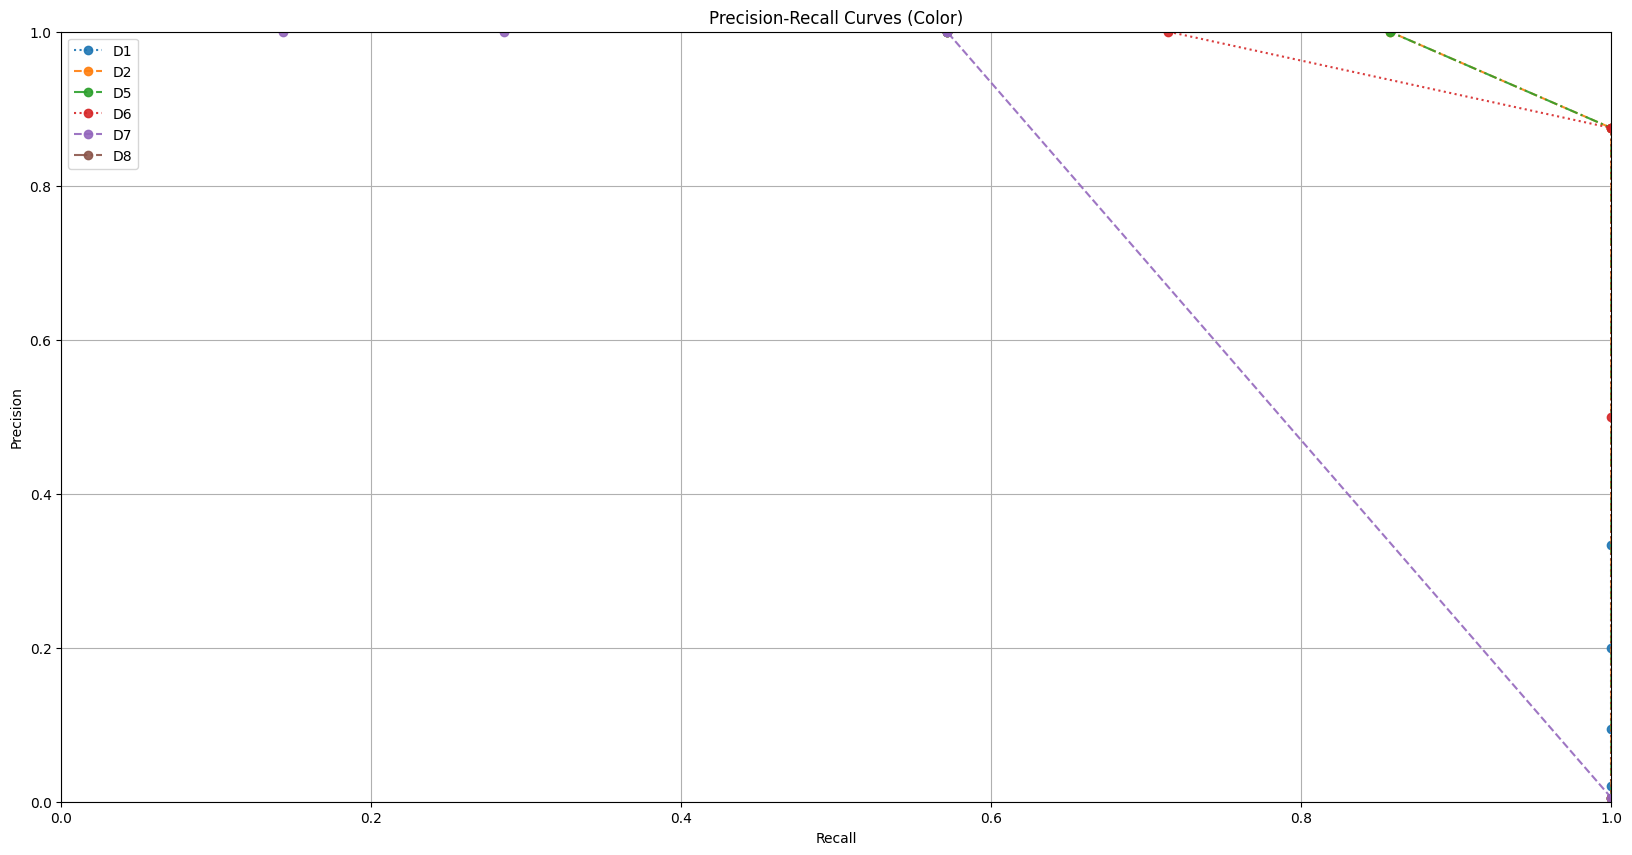

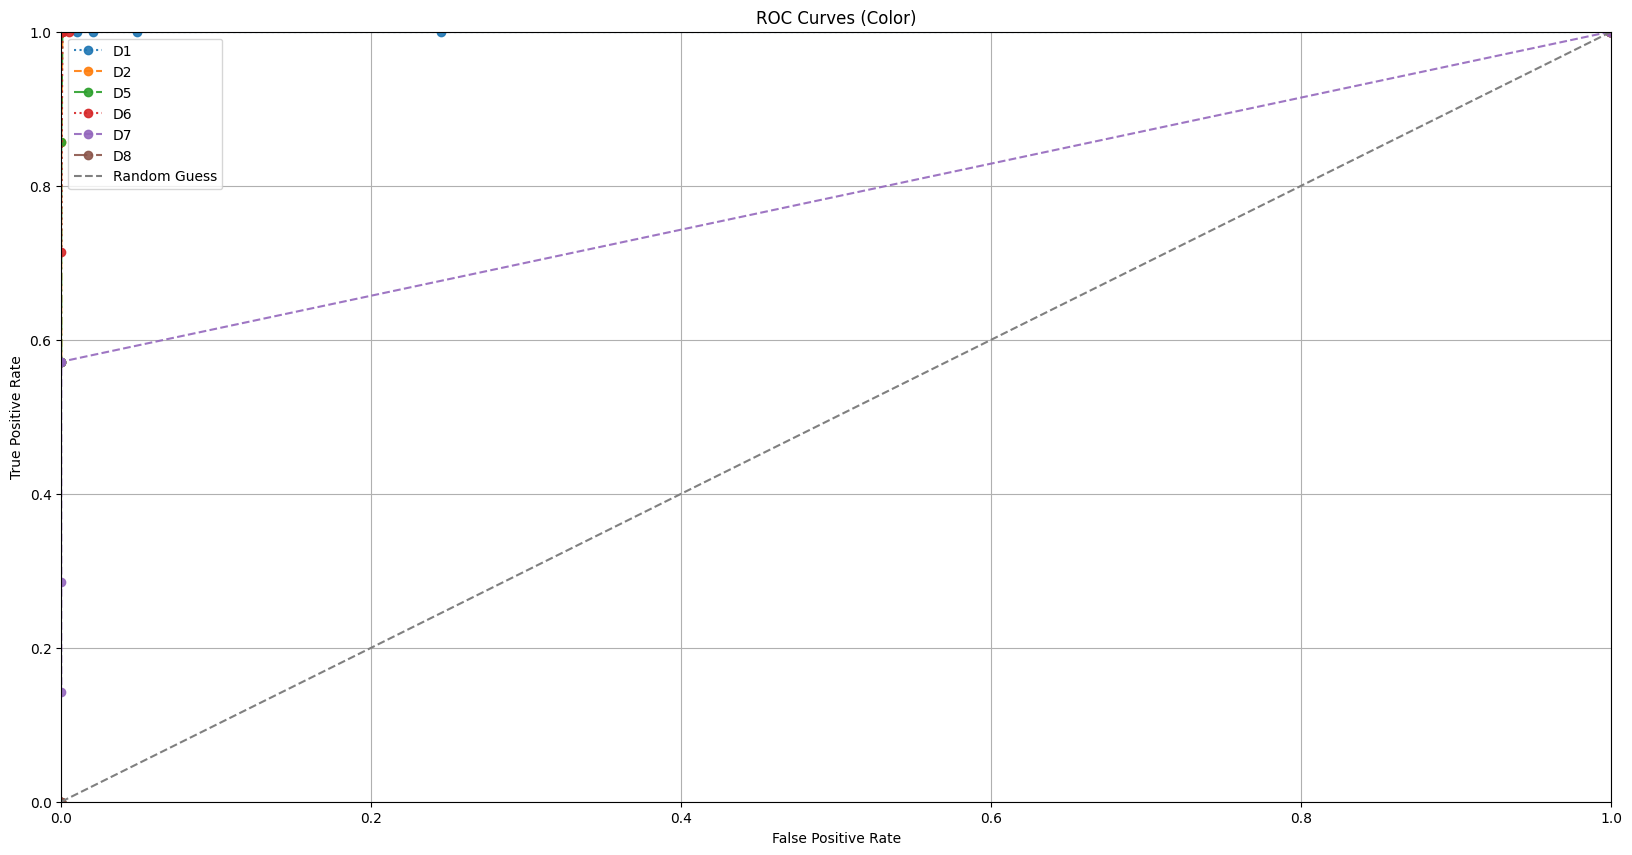

Evaluating Region with D1...
Evaluating Region with D2...
Evaluating Region with D5...
Evaluating Region with D6...
Evaluating Region with D7...


C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\wumin\AppData\Local\Temp\ipykernel_14012\2822785926.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Evaluating Region with D8...
{'D1': [0.010101010101010102, 0.010101010101010102, 0.010108303249097473, 0.010108303249097473, 0.010122921185827912], 'D2': [0.010101010101010102, 0.01079414032382421, 0.015435501653803746, 0.01881720430107527, 0.025225225225225228], 'D5': [0.010101010101010102, 0.01079414032382421, 0.015435501653803746, 0.01881720430107527, 0.025225225225225228], 'D6': [0.010101010101010102, 0.010130246020260494, 0.010378057820607859, 0.011023622047244094, 0.011904761904761906], 'D7': [0.010101010101010102, 1.0, 1.0, 0.6, nan], 'D8': [nan, nan, nan, nan, nan]}


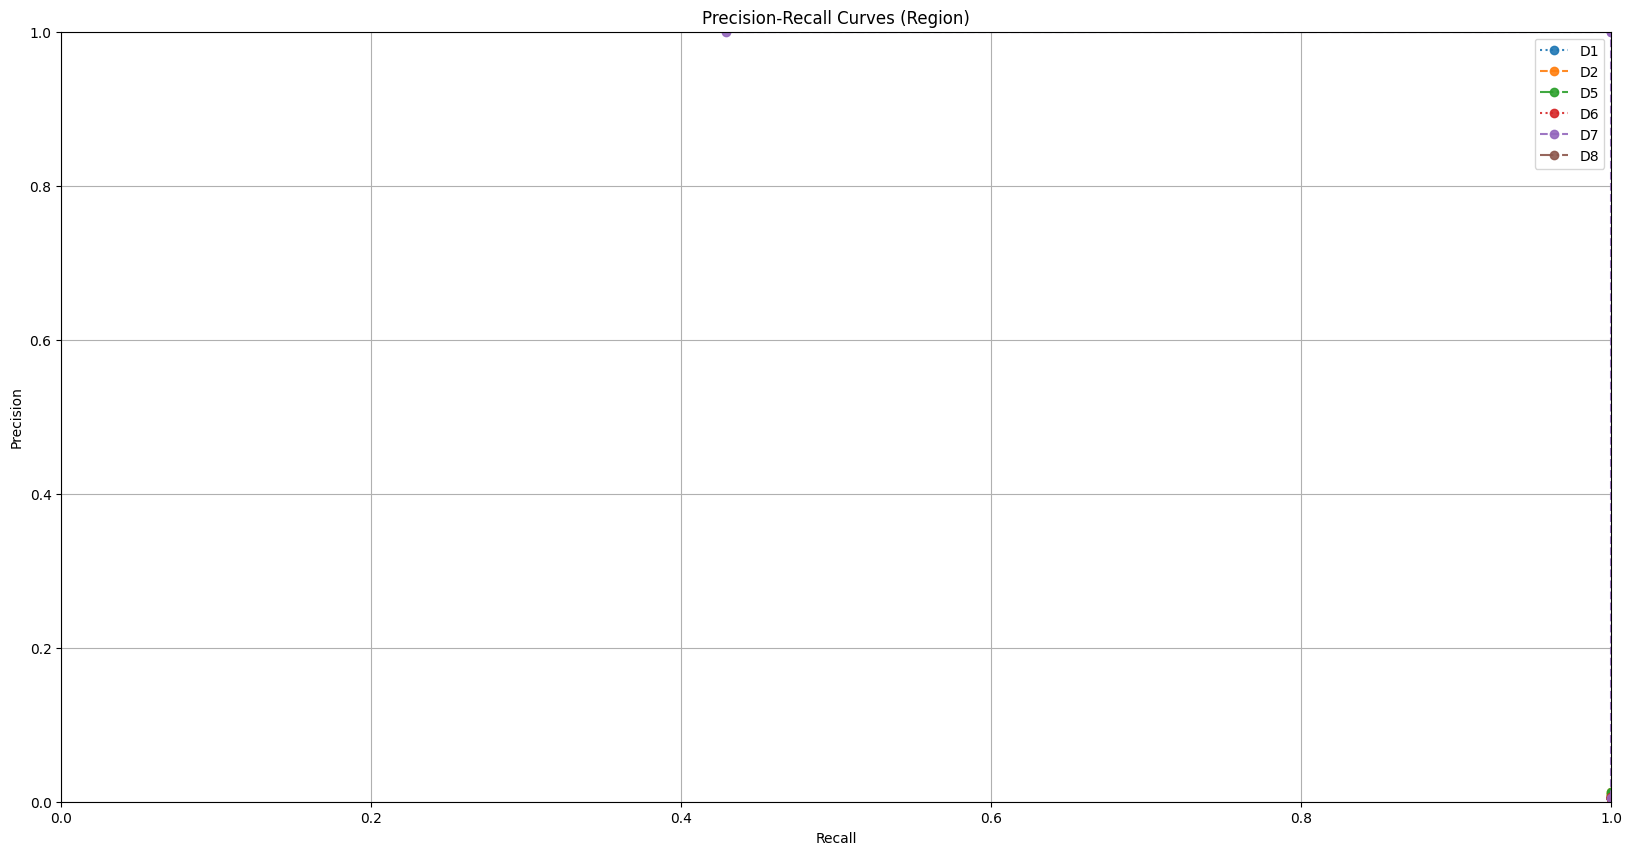

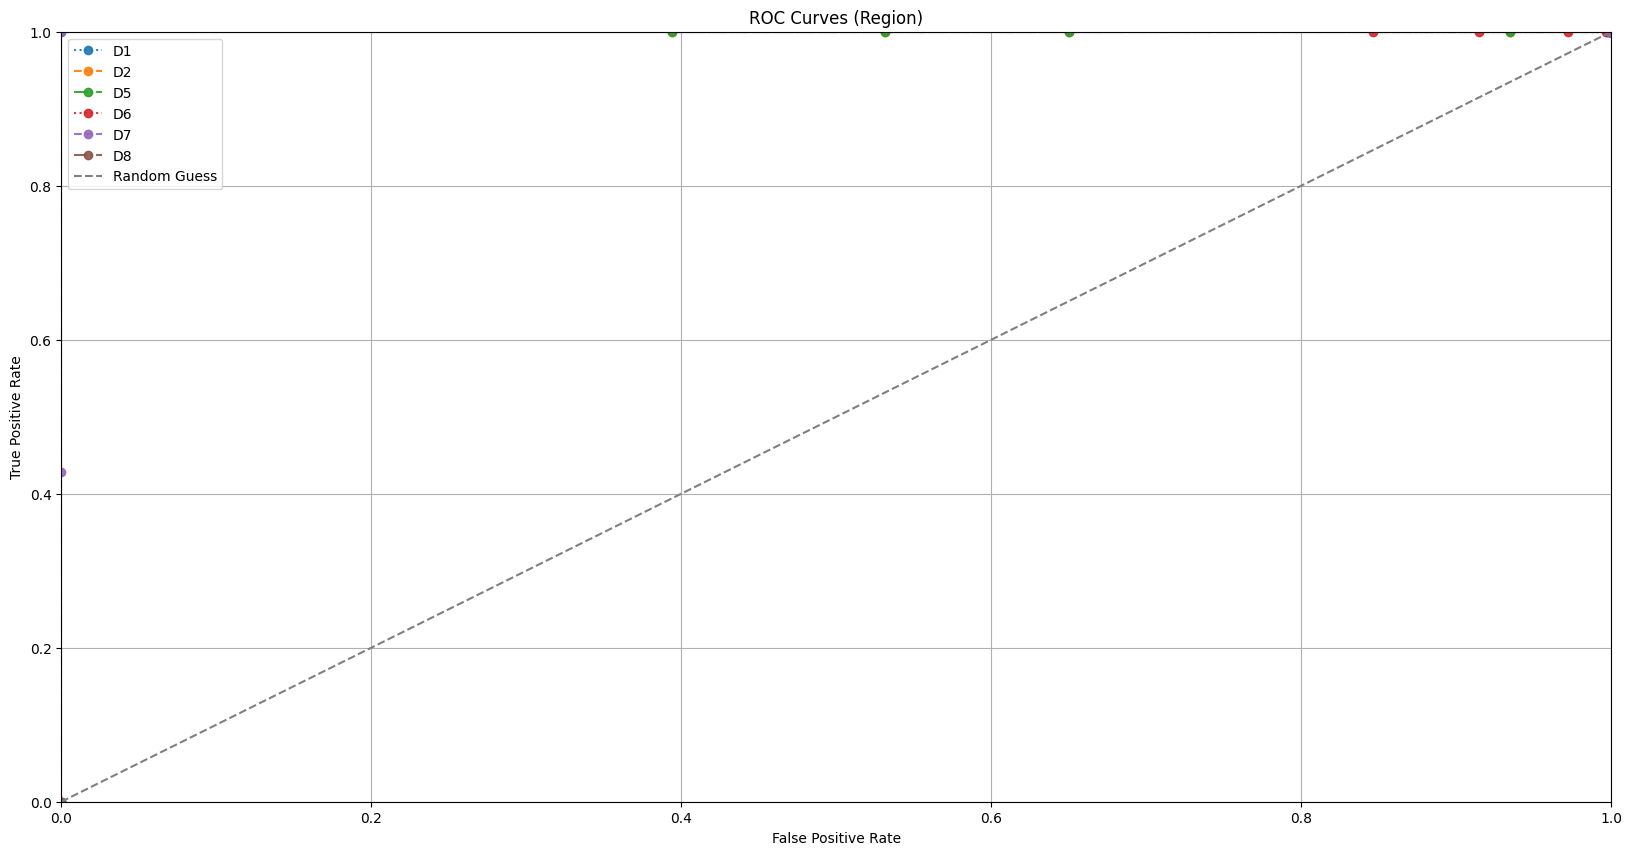

In [15]:
# Evaluate all combinations of features and distance functions, and record the best F1 score
for feature_name, feature in features.items():
    precisions_dict = {}
    recalls_dict = {}
    tprs_dict = {}
    fprs_dict = {}
    f1_dict = {}
    
    for distance_name, distance in distances.items():
        print(f"Evaluating {feature_name} with {distance_name}...")
        precisions, recalls, f1, tprs, fprs = eval(feature, distance, feature_name, distance_name)
        precisions_dict[distance_name] = precisions
        recalls_dict[distance_name] = recalls
        tprs_dict[distance_name] = tprs
        fprs_dict[distance_name] = fprs
        f1_dict[distance_name] = f1
    print(f1_dict)
    plot_pr_curves(precisions_dict, recalls_dict, feature_name)
    plot_roc_curves(tprs_dict, fprs_dict, feature_name)